In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util import util
from util.logUtil import LOG

Using TensorFlow backend.


In [2]:
# variables
macDir = '/Users/etto/Desktop/tpDatasets/'
winDir = 'E:/SAA_DATA/predictiveMaintenance/'
osDir = winDir
data_folder = '../../storedData/'

train_bearings_abbr = ['1_1', '1_2', 
                       '2_1', '2_2', 
                       '3_1', '3_2']
test_bearings_abbr = ['1_3', '1_4', '1_5', '1_6', '1_7', 
                      '2_3', '2_4', '2_5', '2_6', '2_7', 
                      '3_3']
train_bearings = ['Bearing{:s}'.format(bearing) for bearing in train_bearings_abbr]
test_bearings = ['Bearing{:s}'.format(bearing) for bearing in test_bearings_abbr]

train_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in train_bearings]
test_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in test_bearings]

# keys to use
keyHSpec = 'horSpec'
keyHT = 'horT'
keyHF = 'horF'
keyVSpec = 'vertSpec'
keyVT = 'vertT'
keyVF = 'vertF'
keyTempTimstamps = 'tempTimestamps'
keyAccTimestamps = 'timestamps'
keyTemps = 'temperature'

# test specificaties
testspecs = [
    ['1_3', 5730],
    ['1_4', 339],
    ['1_5', 1610],
    ['1_6', 1460],
    ['1_7', 7570],
    ['2_3', 7530],
    ['2_4', 1390],
    ['2_5', 3090],
    ['2_6', 1290],
    ['2_7', 580],
    ['3_3', 820]
]

In [3]:
# utility functions
def getDataFrame(bearingPath, key):
    return pd.read_hdf(path_or_buf=bearingPath, key=key)

def plotTrainResults(X, Y, rulModel, history):
    plt.plot(history.history['loss'])
    plt.show()

    plt.figure()
    predictions = rulModel.predict(X)
    plt.plot(predictions)
    plt.plot(Y)
    plt.show()

def getModelName(layersizes, epochs, kenmerk):
    modelname = 'models/rulModel_' + kenmerk + '_'
    for size in layersizes:
        modelname += '{:d}_'.format(size)
    modelname += '1_ep{:d}.h5'.format(epochs)
    return modelname

def evaluate_spectro(modelnames, spectro, RUL_value, plotname=''):
    # True Y values
    nr_samples = len(spectro)
    Y_values = np.array([10 * (nr_samples - i) + RUL_value for i in range(1, nr_samples + 1)])

    models = [load_model(mname) for mname in modelnames]  # type: Model
    predictions = [(model.predict(spectro), np.sqrt(model.evaluate(spectro, Y_values))) for model in models]

    x_ax_values = [10 * i for i in range(nr_samples)]

    nr = 0
    for (prediction, rms) in predictions:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(x_ax_values, prediction,label='Predicted RUL')

        plt.plot(x_ax_values, Y_values,label='Actual RUL')
        plt.title(modelnames[nr] + ' - RMS: {:.0f}'.format(rms))
        plt.ylabel('RUL (s)')
        plt.xlabel('Running Time (s)')
        plt.legend()

        if len(plotname) > 0:
            plt.savefig('plots/' + plotname, bbox_inches='tight', dpi=300)  # 600
        else:
            plt.show()

        nr += 1

def normalizeMatrix(matrix):
    stdS = np.array([np.std(matrix, axis=1)])
#     varS = stdS**2
    meanS = np.array([np.mean(matrix, axis=1)])
    return (matrix - meanS.T) / stdS.T

def maxNormMatrix(matrix):
    return matrix / np.array([np.max(matrix, axis=1)]).T

### bepaal X en Y voor trainen

In [4]:
spectros_train_hor_org = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in train_files]
spectros_train_vert_org = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in train_files]

spectros_test_hor_org = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in test_files]
spectros_test_vert_org = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in test_files]

spectros_train_hor = [normalizeMatrix(spectro) for spectro in spectros_train_hor_org]
spectros_train_vert = [normalizeMatrix(spectro) for spectro in spectros_train_vert_org]

spectros_test_hor = [normalizeMatrix(spectro) for spectro in spectros_test_hor_org]
spectros_test_vert = [normalizeMatrix(spectro) for spectro in spectros_test_vert_org]

X_train = np.concatenate((np.concatenate(spectros_train_hor, axis=0),
                          np.concatenate(spectros_train_vert, axis=0)), 
                          axis=1)
print(np.shape(X_train))

Y_train = []
for spectro in spectros_train_hor:
    nr_samples = len(spectro)
    Y_train_nw = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])
    Y_train = np.append(Y_train, Y_train_nw)
    
print(np.shape(Y_train))

(7534, 2562)
(7534,)


In [5]:
# parameters
testspecs = [
    ['1_3', 5730],
    ['1_4', 339],
    ['1_5', 1610],
    ['1_6', 1460],
    ['1_7', 7570],
    ['2_3', 7530],
    ['2_4', 1390],
    ['2_5', 3090],
    ['2_6', 1290],
    ['2_7', 580],
    ['3_3', 820]
]

## experiments

Epoch 1/60
7534/7534 [==============================] - 4s 535us/step - loss: 21828668.2907
Epoch 2/60
7534/7534 [==============================] - 2s 201us/step - loss: 1863781.9886
Epoch 3/60
7534/7534 [==============================] - 2s 211us/step - loss: 1225970.8096
Epoch 4/60
7534/7534 [==============================] - 1s 198us/step - loss: 961303.9717
Epoch 5/60
7534/7534 [==============================] - 2s 211us/step - loss: 772009.5450
Epoch 6/60
7534/7534 [==============================] - 2s 241us/step - loss: 584810.9126
Epoch 7/60
7534/7534 [==============================] - 1s 194us/step - loss: 474475.6217
Epoch 8/60
7534/7534 [==============================] - 2s 200us/step - loss: 399819.5092
Epoch 9/60
7534/7534 [==============================] - 2s 235us/step - loss: 322446.3982
Epoch 10/60
7534/7534 [==============================] - 2s 244us/step - loss: 252834.0613
Epoch 11/60
7534/7534 [==============================] - 1s 196us/step - loss: 204443.3279
Epoc

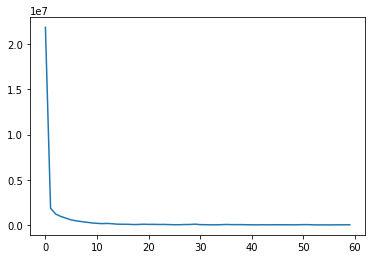

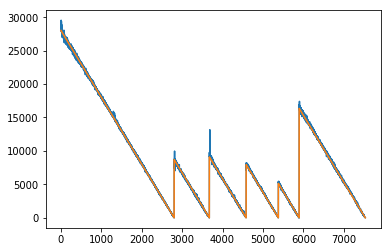

Epoch 1/75
7534/7534 [==============================] - 2s 300us/step - loss: 15960316.9162
Epoch 2/75
7534/7534 [==============================] - 2s 221us/step - loss: 1623128.3825
Epoch 3/75
7534/7534 [==============================] - 1s 198us/step - loss: 1097112.1747
Epoch 4/75
7534/7534 [==============================] - 2s 267us/step - loss: 826063.6612
Epoch 5/75
7534/7534 [==============================] - 2s 253us/step - loss: 682939.2957
Epoch 6/75
7534/7534 [==============================] - 1s 177us/step - loss: 523224.1473
Epoch 7/75
7534/7534 [==============================] - 1s 167us/step - loss: 404673.0717
Epoch 8/75
7534/7534 [==============================] - 1s 174us/step - loss: 343915.0944
Epoch 9/75
7534/7534 [==============================] - 1s 190us/step - loss: 271855.2742
Epoch 10/75
7534/7534 [==============================] - 1s 190us/step - loss: 246907.6136
Epoch 11/75
7534/7534 [==============================] - 2s 204us/step - loss: 207003.6207
Epoc

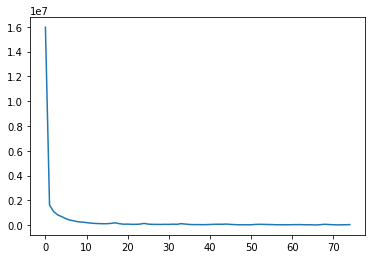

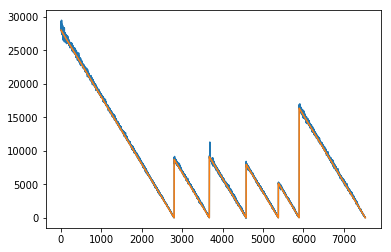

In [6]:
expName = 'exp20180710_max_norm'
layersizes = [600,300,150,25]
epochss = [60, 75]
for epochs in epochss:
    rulModel, history = util.trainModel(X_train, Y_train, layersizes, epochs, expName)

##################
# Test: 1_3
##################
1802/1802 [==============================] - 0s 102us/step


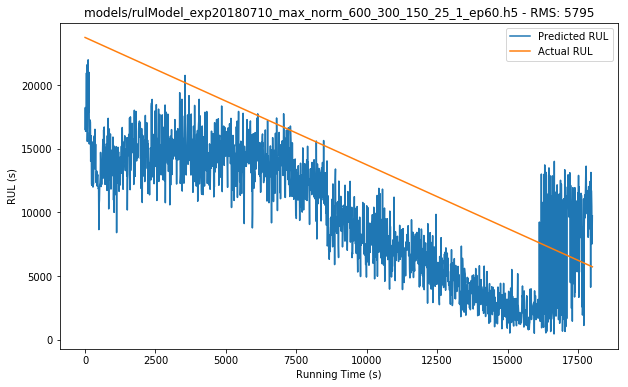

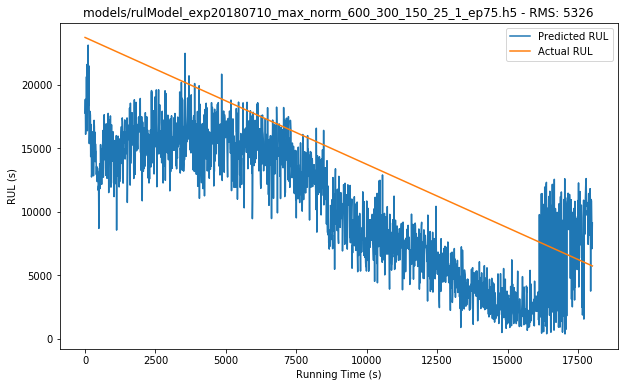

##################
# Test: 1_4
##################
1139/1139 [==============================] - 0s 159us/step


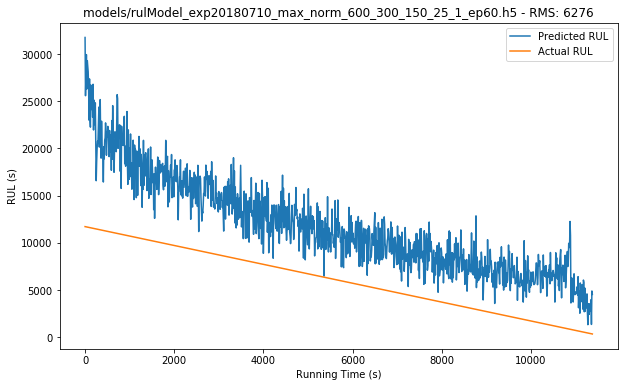

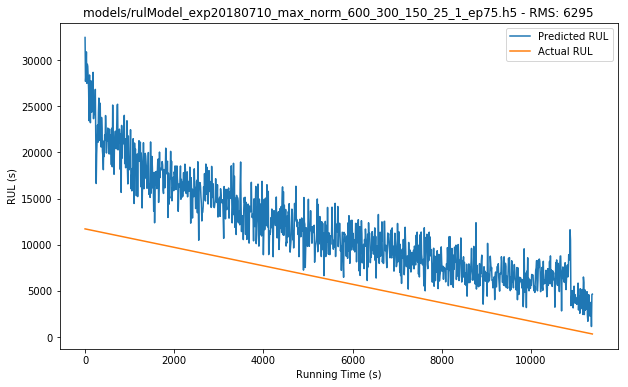

##################
# Test: 1_5
##################
2302/2302 [==============================] - 0s 138us/step


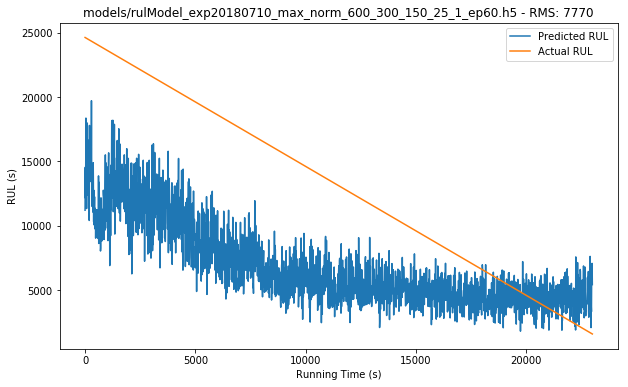

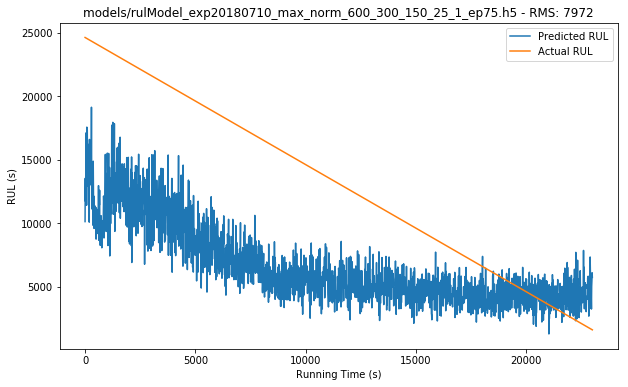

##################
# Test: 1_6
##################
2302/2302 [==============================] - 1s 233us/step


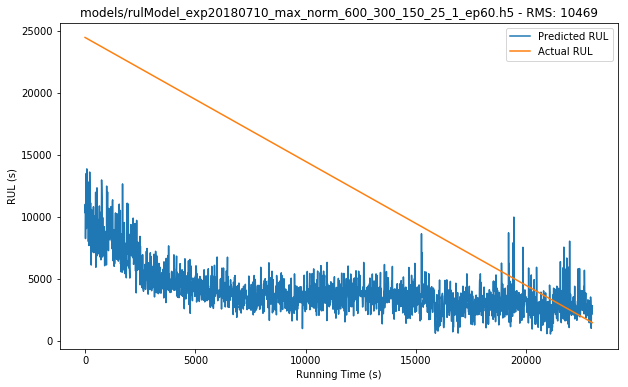

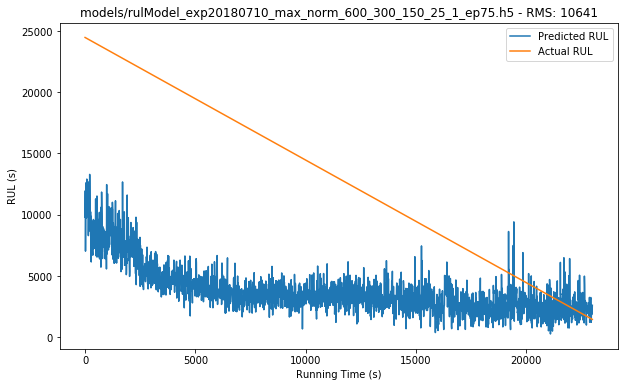

##################
# Test: 1_7
##################
1502/1502 [==============================] - 0s 236us/step


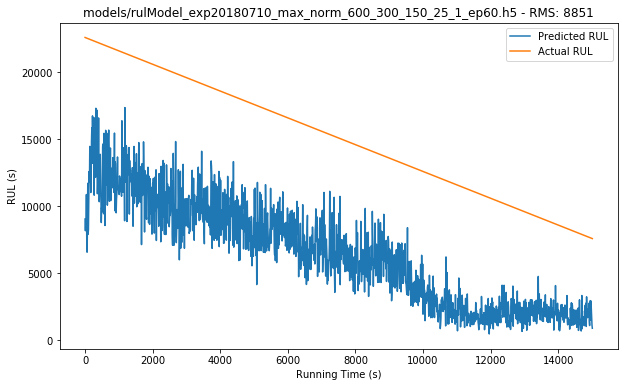

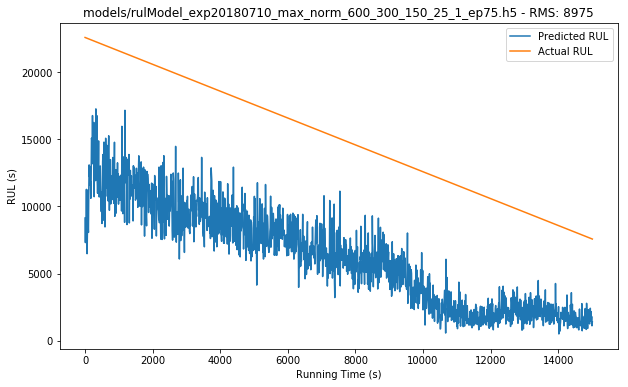

##################
# Test: 2_3
##################
1202/1202 [==============================] - 0s 288us/step


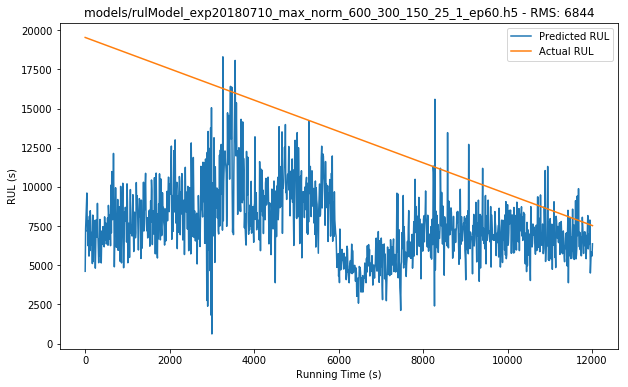

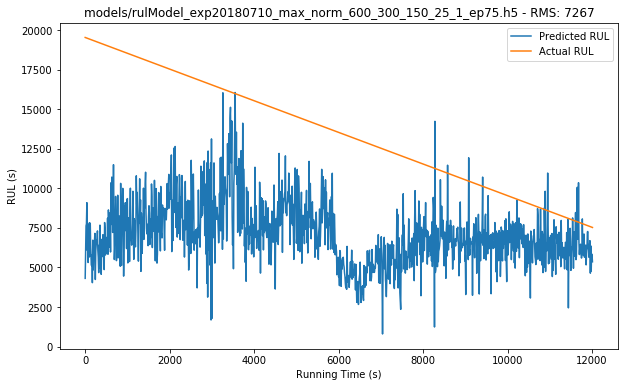

##################
# Test: 2_4
##################
612/612 [==============================] - 0s 704us/step


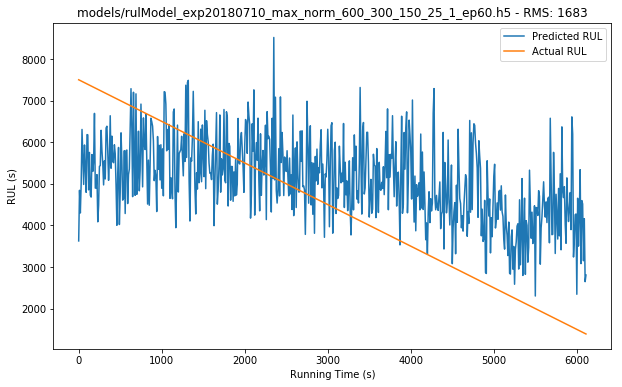

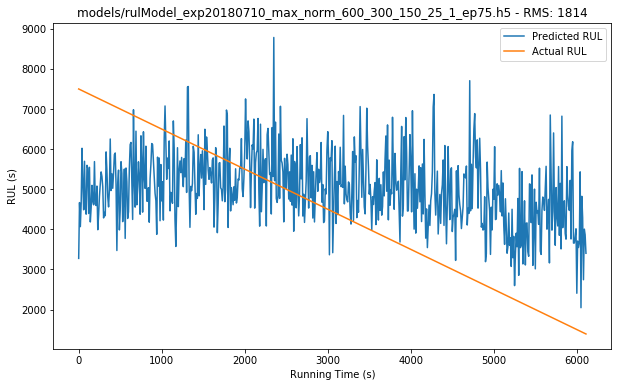

##################
# Test: 2_5
##################
2002/2002 [==============================] - 0s 231us/step


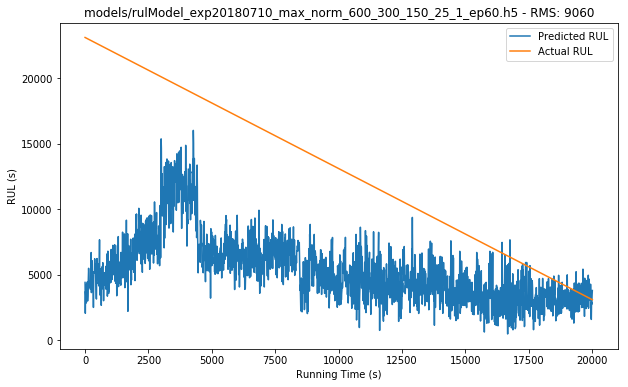

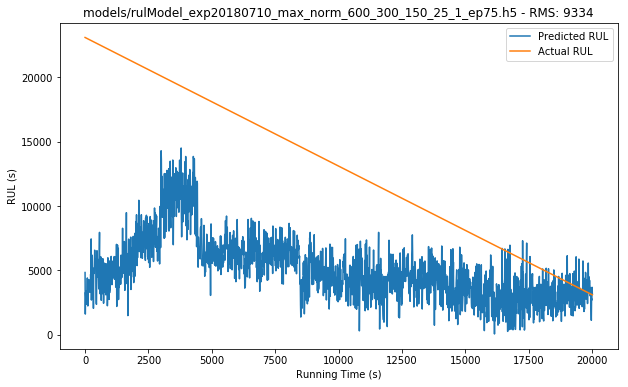

##################
# Test: 2_6
##################
572/572 [==============================] - 0s 800us/step


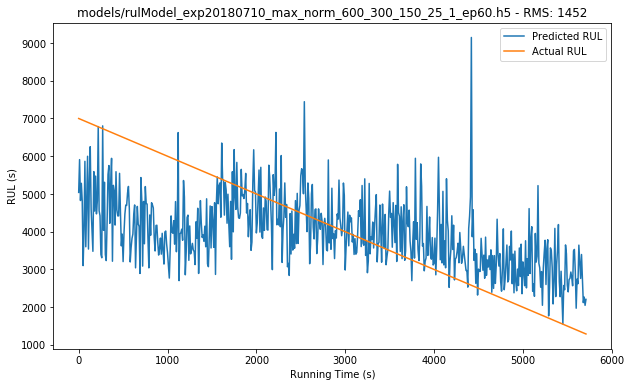

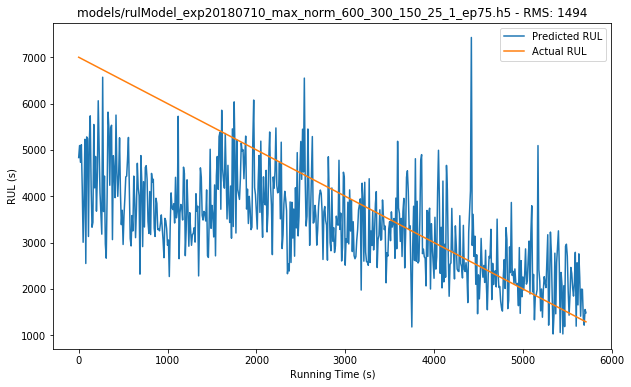

##################
# Test: 2_7
##################
172/172 [==============================] - 0s 3ms/step


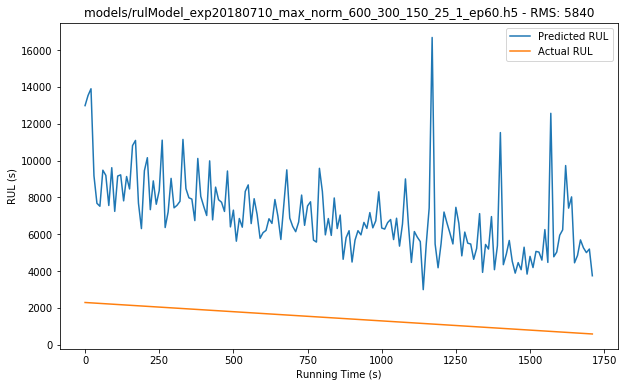

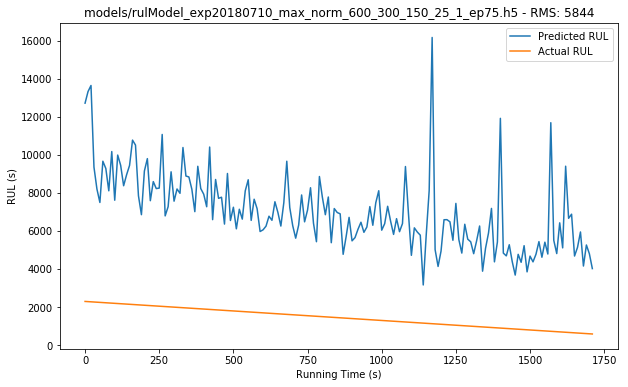

##################
# Test: 3_3
##################
352/352 [==============================] - 1s 2ms/step


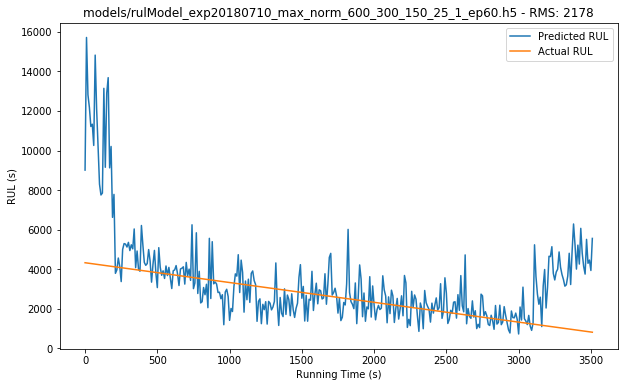

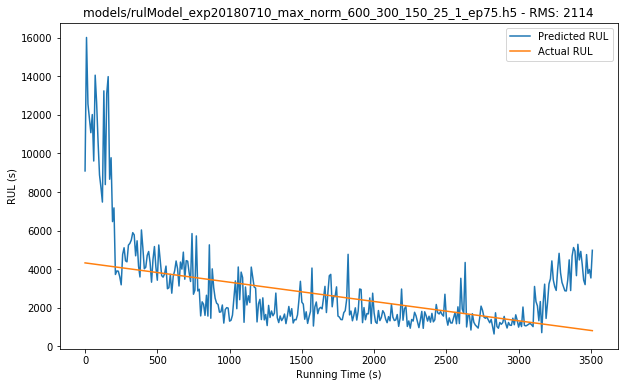

In [7]:
for testIndex in range(len(testspecs)):
    print('##################\n# Test: {:s}\n##################'.format(testspecs[testIndex][0]))
    actRUL =  testspecs[testIndex][1]
    testSpectro = np.concatenate((spectros_test_hor[testIndex], spectros_test_vert[testIndex]), axis=1)
    modelnames = [util.getModelName(layersizes, epochs, expName) for epochs in epochss]
    util.evaluate_spectro(modelnames, testSpectro, actRUL)